In [1]:
from functools import reduce
from pathlib import Path
from typing import Literal, Sized, Union, cast

import hydra
import numpy as np
import pandas as pd
import torch
from omegaconf import OmegaConf

from move.conf.schema import (
    IdentifyAssociationsBayesConfig,
    IdentifyAssociationsConfig,
    IdentifyAssociationsTTestConfig,
    MOVEConfig,
)
from move.core.logging import get_logger
from move.core.typing import FloatArray, IntArray
from move.data import io
from move.data.dataloaders import MOVEDataset, make_dataloader
from move.data.perturbations import perturb_categorical_data
from move.data.preprocessing import one_hot_encode_single
from move.models.vae import VAE

In [157]:
! pwd

/Users/wkq953/Desktop/CPR/4. codes/move/tutorial


In [3]:
cd ..

/Users/wkq953/Desktop/CPR/4. codes/move/tutorial


# 1. Initial data and model 

In [7]:
from move.tasks import encode_data
config = io.read_config("random_test", "encode_data")
encode_data(config.data)
path = Path(config.data.interim_data_path)
cat_datasets, cat_names, con_datasets, con_names = io.load_preprocessed_data(path, config.data.categorical_names, config.data.continuous_names)
dataset_names = config.data.categorical_names + config.data.continuous_names
for dataset, dataset_name in zip(cat_datasets + con_datasets, dataset_names):
    print(f"{dataset_name}: {dataset.shape}")

[INFO  - encode_data]: Beginning task: encode data
[INFO  - encode_data]: Encoding 'random.test.drugs'
[INFO  - encode_data]: Encoding 'random.test.metagenomics'
[INFO  - encode_data]: Encoding 'random.test.proteomics'


random.test.drugs: (1000, 20, 2)
random.test.metagenomics: (1000, 50, 2)
random.test.proteomics: (1000, 30)


In [ ]:
#! move-dl experiment=random_test__tune_reconstruction_overfit
! move-dl experiment=random_test__tune_stability

In [174]:
# check the result
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#results = pd.read_csv("results_test/tune_model/results_beta0001.csv", sep=",")
config = io.read_config("random_test", "encode_data")
output_path = Path(config.data.results_path) / "tune_model"
results = pd.read_csv("results_test/tune_model/reconstruction_stats.tsv", sep="\t")
hidden_number_list = ["[200]", "[300]", "[400]"]
beta_list = [0.0005, 0.001]

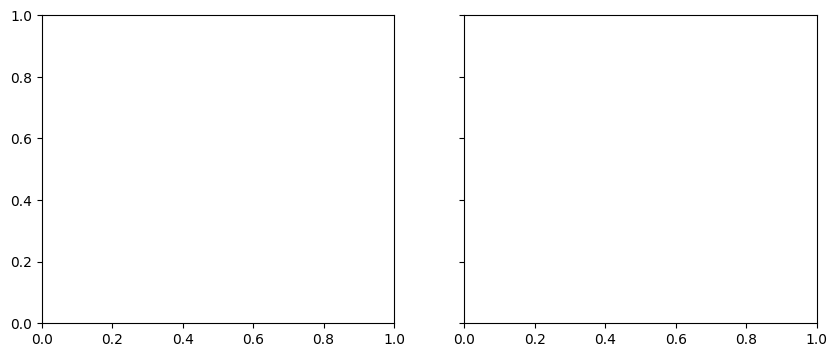

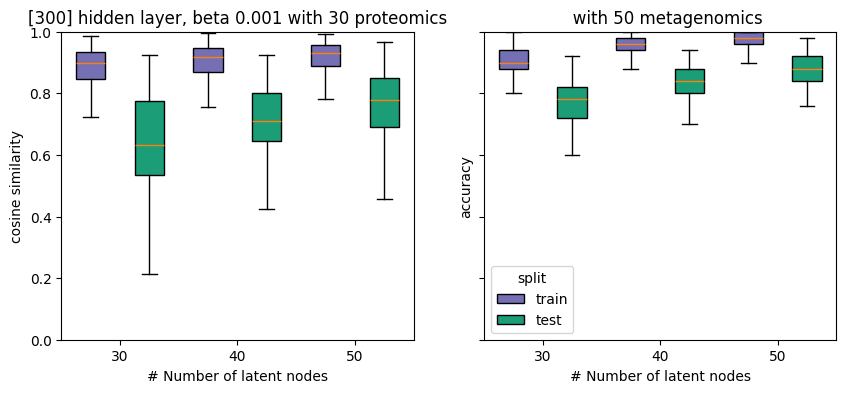

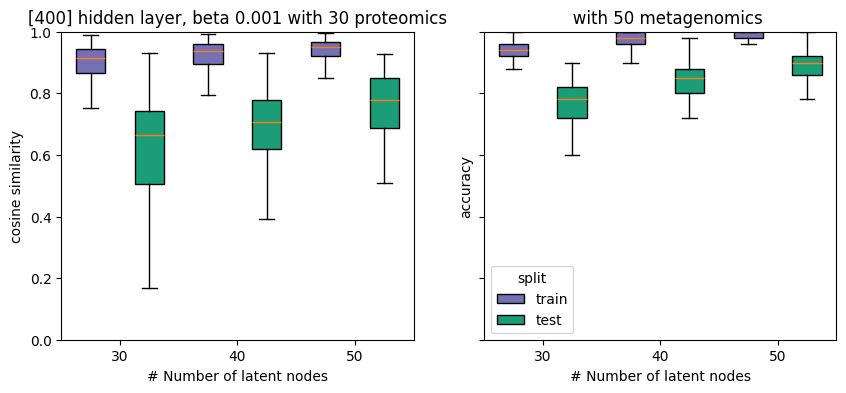

In [175]:
for beta in beta_list:
    for hidden_number in hidden_number_list:
    
        plot_data = results[lambda df: (df["task.model.num_hidden"] == hidden_number)& (df["task.model.beta"] == beta)]

        prot_g1 = plot_data[lambda df: (df["dataset"] == "random.test.proteomics") & (df["split"] == "train") ]
        prot_g1_stats = prot_g1.to_dict(orient="records")

        prot_g2 = plot_data[lambda df: (df["dataset"] == "random.test.proteomics") & (df["split"] == "test") ]
        prot_g2_stats = prot_g2.to_dict(orient="records")

        prot_g3 = plot_data[lambda df: (df["dataset"] == "random.test.metagenomics") & (df["split"] == "train")]
        prot_g3_stats = prot_g3.to_dict(orient="records")

        prot_g4 = plot_data[lambda df: (df["dataset"] == "random.test.metagenomics") & (df["split"] == "test")]
        prot_g4_stats = prot_g4.to_dict(orient="records")

        # matplotlib complains if fliers are unset
        for bxp_stats in chain(prot_g1_stats, prot_g2_stats, prot_g3_stats, prot_g4_stats):
            bxp_stats["fliers"] = []
        fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

        coll1 = axs[0].bxp(prot_g1_stats, positions=[*range(0, 6, 2)], boxprops=dict(facecolor="#7570b3"), patch_artist=True)
        coll2 = axs[0].bxp(prot_g2_stats, positions=[*range(1, 6, 2)], boxprops=dict(facecolor="#1b9e77"), patch_artist=True)

        axs[1].bxp(prot_g3_stats, positions=[*range(0, 6, 2)], boxprops=dict(facecolor="#7570b3"), patch_artist=True)
        axs[1].bxp(prot_g4_stats, positions=[*range(1, 6, 2)], boxprops=dict(facecolor="#1b9e77"), patch_artist=True)

        axs[0].set(
            xticks=np.arange(0.5, 6, 2), xticklabels=[30, 40, 50], ylim=(0, 1),
            xlabel="# Number of latent nodes", ylabel="cosine similarity", title=f"{hidden_number} hidden layer, beta {beta} with 30 proteomics",
        )
        axs[1].set(
            xticks=np.arange(0.5, 6, 2), xticklabels=[30, 40, 50], ylim=(0, 1),
            xlabel="# Number of latent nodes", ylabel="accuracy", title="   with 50 metagenomics"
        )

        axs[1].legend([coll1["boxes"][0], coll2["boxes"][0]], ["train", "test"], title="split")

        plt.savefig(output_path / f"model_reconstruction_hidden_{hidden_number}_beta_{beta}.png", dpi=300, bbox_inches="tight")
        plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

coll1 = axs[0].bxp(prot_g1_stats, positions=[*range(0, 6, 2)], boxprops=dict(facecolor="#7570b3"), patch_artist=True)
coll2 = axs[0].bxp(prot_g2_stats, positions=[*range(1, 6, 2)], boxprops=dict(facecolor="#1b9e77"), patch_artist=True)

axs[1].bxp(prot_g3_stats, positions=[*range(0, 6, 2)], boxprops=dict(facecolor="#7570b3"), patch_artist=True)
axs[1].bxp(prot_g4_stats, positions=[*range(1, 6, 2)], boxprops=dict(facecolor="#1b9e77"), patch_artist=True)

axs[0].set(
    xticks=np.arange(0.5, 6, 2), xticklabels=[10, 20, 30], ylim=(0, 1),
    xlabel="# Number of latent nodes", ylabel="cosine similarity", title=f"Fixed {hidden_number} hidden layer with 30 proteomics",
)
axs[1].set(
    xticks=np.arange(0.5, 6, 2), xticklabels=[10, 20, 30], ylim=(0, 1),
    xlabel="# Number of latent nodes", ylabel="accuracy", title=f"Fixed hidden {hidden_number} hidden layer with 50 metagenomics"
)

axs[1].legend([coll1["boxes"][0], coll2["boxes"][0]], ["train", "test"], title="split")

plt.savefig(output_path / f"model_reconstruction_hidden_{hidden_number}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from move.tasks import analyze_latent
#config = io.read_config("random_catagorical", "random_catagorical__latent")
config = io.read_config("random_test", "random_test__latent")
analyze_latent(config)

# 2. Association 

In [67]:
from move.conf.schema import MOVEConfig
from move.tasks import identify_associations
config = io.read_config("random_test", "random_test__id_assoc_bayes_cat_para2")
#config = io.read_config("random_test", "random_test__id_assoc_bayes")

In [68]:
identify_associations(config)

[INFO  - identify_associations]: Perturbing dataset: 'random.test.drugs'
[INFO  - identify_associations]: Beginning task: identify associations categorical


[INFO  - identify_associations]: Training models
[INFO  - identify_associations]: Identifying significant features
[INFO  - identify_associations]: Significant hits found: 999
[INFO  - identify_associations]: Writing results


In [26]:
prob = np.array([0.01, 0.05, 0.03, 0.2,0.0000001])
prob = np.sort(prob)

# Calculate FDR
fdr = np.cumsum(1 - prob) / np.arange(1, prob.size + 1)
fdr
np.abs(fdr - 0.9)
np.argmin(np.abs(fdr - 0.9)) 

array([0.9999999 , 0.99499995, 0.98666663, 0.97749997, 0.94199998])

# 3. Result Analysis

In [40]:
truth = pd.read_csv("data/changes.test.txt",  sep="\t")
truth = truth[~(truth["feature_a_name"].str.contains("Proteomics") | truth["feature_a_name"].str.contains("Drugs"))]
predict = pd.read_csv("results_test/identify_associations/results_sig_assoc_bayes.tsv", sep="\t")

### Reconstruction in predict

In [69]:
# Path
#config = io.read_config("random_test", "random_test__id_assoc_bayes_cat_para2")
#config = io.read_config("random_test", "random_test__id_assoc_bayes")
task_config = cast(IdentifyAssociationsConfig, config.task)
interim_path = Path(config.data.interim_data_path)
models_path = interim_path / "models"
if task_config.save_refits:
    models_path.mkdir(exist_ok=True)

In [70]:
cat_list, cat_names, con_list, con_names = io.load_preprocessed_data(
    Path(config.data.interim_data_path), config.data.categorical_names, config.data.continuous_names
    )
baseline_dataloader = make_dataloader(
    cat_list, con_list, shuffle=False, batch_size=config.task.batch_size
    )

baseline_dataset = cast(MOVEDataset, baseline_dataloader.dataset)
target_dataset_idx = config.data.categorical_names.index(task_config.target_dataset)

train_dataloader = make_dataloader(
    cat_list, con_list, shuffle=True, batch_size=task_config.batch_size, drop_last=True,
)

device = torch.device("cuda" if task_config.model.cuda == True else "cpu")

In [71]:
baseline_redrug = []
baseline_recat = []
for j in range(task_config.num_refits):
    # Initialize model
    model: VAE = hydra.utils.instantiate(
        task_config.model,
        continuous_shapes=baseline_dataset.con_shapes,
        categorical_shapes=baseline_dataset.cat_shapes,
    )
    # Train/reload model
    model_path = models_path / f"model_{task_config.model.num_latent}_{j}.pt"
    if model_path.exists():
        model.load_state_dict(torch.load(model_path))
        model.to(device)
    else:
        model.to(device)
        hydra.utils.call(
            task_config.training_loop,
            model=model,
            train_dataloader=train_dataloader,
        )
        if task_config.save_refits:
            torch.save(model.state_dict(), model_path)
    model.eval()
    baseline_recat_all, _ = model.reconstruct(baseline_dataloader)
    baseline_redrug.append(baseline_recat_all[target_dataset_idx])
    baseline_recat.append(baseline_recat_all[target_dataset_idx+1])

## violin

In [95]:
def plot_association(redrug, recat, drug_index, meta_index, output_path): 
    drug_i_all = np.array([])
    meta_i_all = np.array([])
    for j in range(task_config.num_refits):
        drug_i = redrug[j][:,drug_index]
        meta_i = recat[j][:, meta_index]
        drug_i_all = np.append(drug_i_all, drug_i)
        meta_i_all = np.append(meta_i_all, meta_i)
        drug_i_all.flatten()
        meta_i_all.flatten()
    sns.violinplot(data = [drug_i_all, meta_i_all])
    label = [f"Drug_{drug_index+1}", f"Metagenomic_{meta_index+1}"]
    plt.xlabel("Dataset")
    plt.ylabel("Catagory")
    plt.xticks(ticks = [0, 1], labels = label, fontsize = 11)
    plt.yticks([0,1],fontsize = 11)
    plt.title(f"Association between drug {drug_index+1} and metagenomic {meta_index+1}")
    plt.savefig(output_path / f"Association_drug {drug_index+1} and metagenomic{meta_index+1}.png", dpi=300, bbox_inches="tight")
    plt.show()
drug_i = 17
meta_i = 47
plot_association(baseline_redrug, baseline_recat,  drug_i, meta_i, output_path)


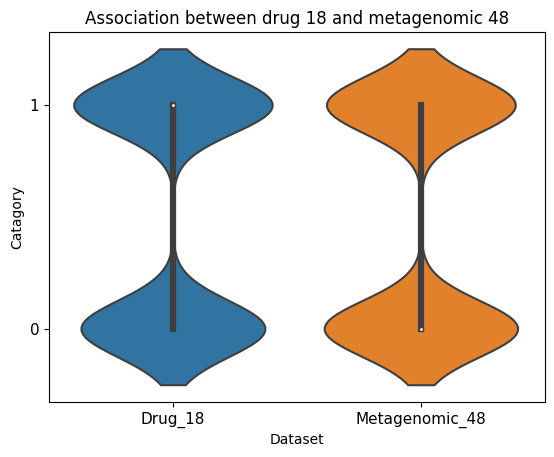

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
output_path = Path(config.data.results_path) / "identify_associations"
drug= pd.read_csv("data/random.test.drugs.tsv", sep="\t")
meta = pd.read_csv("data/random.test.metagenomics.tsv", sep="\t")
drug_index = 18
meta_index = 48
sns.violinplot(data = [drug.iloc[:,drug_index], meta.iloc[:,meta_index]])
label = [f"Drug_{drug_index}", f"Metagenomic_{meta_index}"]
plt.xlabel("Dataset")
plt.ylabel("Catagory")
plt.xticks(ticks = [0, 1], labels = label, fontsize = 11)
plt.yticks([0,1],fontsize = 11)
plt.title(f"Association between drug {drug_index} and metagenomic {meta_index}")
plt.savefig(output_path / f"Association_drug {drug_index} and metagenomic{meta_index}_ori.png", dpi=300, bbox_inches="tight")
plt.show()

## confusion matrix

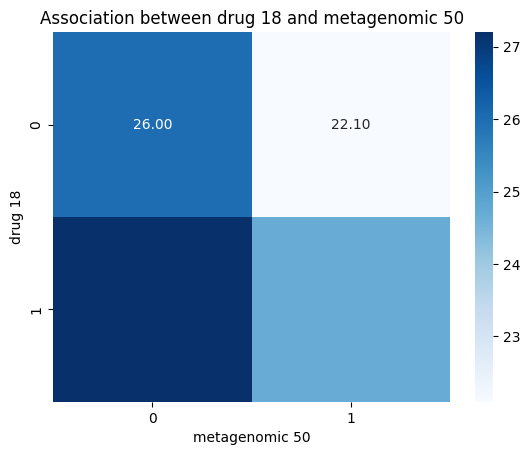

In [145]:
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
output_path = Path(config.data.results_path) / "identify_associations"
drug= pd.read_csv("data/random.test.drugs.tsv", sep="\t")
meta = pd.read_csv("data/random.test.metagenomics.tsv", sep="\t")
drug_index = 18
meta_index =50
drug_i = drug.iloc[:,drug_index]
meta_i = meta.iloc[:,meta_index]
pairs = list(zip(drug.iloc[:,drug_index].astype(int), meta.iloc[:,meta_index].astype(int)))
pair_counts = Counter(pairs)
total_count = len(pairs)
# Calculate percentages
percentages = {k: (v / total_count * 100) for k, v in pair_counts.items()}
# Create confusion matrix
conf_matrix = np.zeros((2, 2))
for (a, b), perc in percentages.items():
    conf_matrix[a, b] = perc

# Plot
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel(f'drug {drug_index}')
plt.xlabel(f'metagenomic {meta_index}')
plt.title(f"Association between drug {drug_index} and metagenomic {meta_index}")
plt.savefig(output_path / f"Confusion_drug {drug_index} and metagenomic{meta_index}_ori.png", dpi=300, bbox_inches="tight")
plt.show()

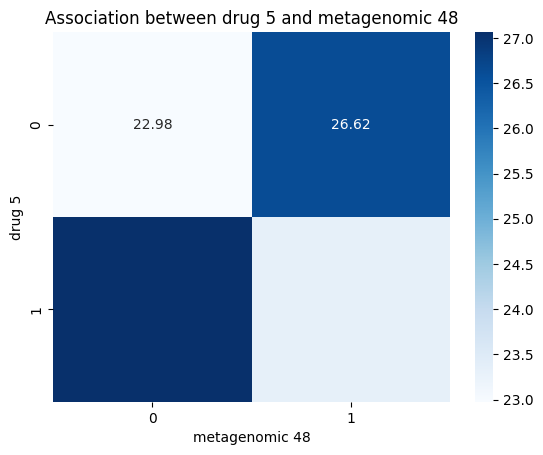

In [151]:
def plot_association_conf(redrug, recat, drug_index, meta_index, output_path): 
    drug_i_all = np.array([])
    meta_i_all = np.array([])
    for j in range(task_config.num_refits):
        drug_i = redrug[j][:,drug_index]
        meta_i = recat[j][:, meta_index]
        drug_i_all = np.append(drug_i_all, drug_i)
        meta_i_all = np.append(meta_i_all, meta_i)
        drug_i_all.flatten()
        meta_i_all.flatten()
    pairs = list(zip(drug_i_all.astype(int), meta_i_all.astype(int)))
    pair_counts = Counter(pairs)
    total_count = len(pairs)
    # Calculate percentages
    percentages = {k: (v / total_count * 100) for k, v in pair_counts.items()}
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for (a, b), perc in percentages.items():
        conf_matrix[a, b] = perc
    # Plot
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=[0, 1], yticklabels=[0, 1])
    plt.ylabel(f'drug {drug_index+1}')
    plt.xlabel(f'metagenomic {meta_index+1}')
    plt.title(f"Association between drug {drug_index+1} and metagenomic {meta_index+1}")
    plt.savefig(output_path / f"Confusion_drug {drug_index+1} and metagenomic{meta_index+1}.png", dpi=300, bbox_inches="tight")
    plt.show()
drug_i = 4
meta_i = 47
plot_association_conf(baseline_redrug, baseline_recat,  drug_i, meta_i, output_path)

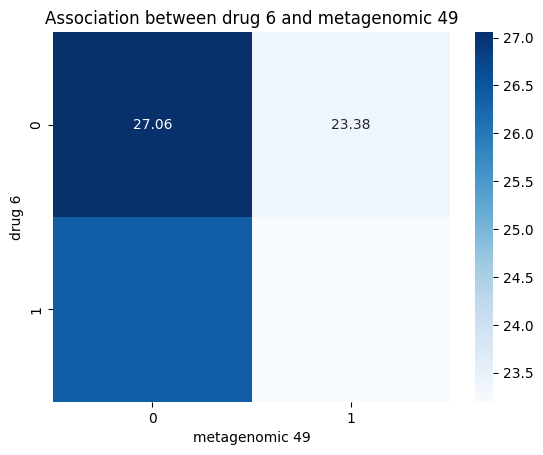

In [153]:
drug_i = 5
meta_i = 48
plot_association_conf(baseline_redrug, baseline_recat,  drug_i, meta_i, output_path)